<a href="https://colab.research.google.com/github/31Wilson13/ntnu_11302generativeAI/blob/main/HW2/%E5%8F%B0%E5%B8%AB%E5%A4%A7_612K0031C_AI%E6%89%80%E7%A2%A9%E4%BA%8C_%E7%B0%A1%E7%85%92%E5%93%B2_%E4%BD%9C%E6%A5%AD%E4%BA%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業目標：開發一個簡易的神經網路模型來對MNIST資料集進行手寫數字識別

## 模型中各層神經元的數量設置

設計理念為嘗試打造一個多層的神經網路：第一層隱藏層包含30個神經元，第二層隱藏層包含20個神經元，第三層隱藏層包含10個神經元，第四層隱藏層包含20個神經元，第五層隱藏層包含30個神經元，最後輸出層則是對應有10個數字，因此設為10個神經元

In [1]:
N1 = 30
N2 = 20
N3 = 10
N4 = 20
N5 = 30
N6 = 10

## 1. 讀入套件

此套件用於最終的互動式成果展現

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [3]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路方面
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout

# 互動設計用
from ipywidgets import interact_manual

# 神速打造 web app 的 Gradio
import gradio as gr

## 2. 讀入 MNIST 數據庫


MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的[原始網頁](http://yann.lecun.com/exdb/mnist/)。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

### 2.1 由 Keras 讀入 MNIST

Keras 內已設置好MNIST 數據庫, 可以直接讀入

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2.2 輸入格式整理

現在要用標準神經網路學學手寫辨識。原來的每筆數據是個 28x28 的矩陣 (array), 但標準神經網路只吃「平平的」, 也就是每次要 28x28=784 長的向量。因此要用 `reshape` 調校一下。

In [5]:
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

### 2.3 輸出格式整理
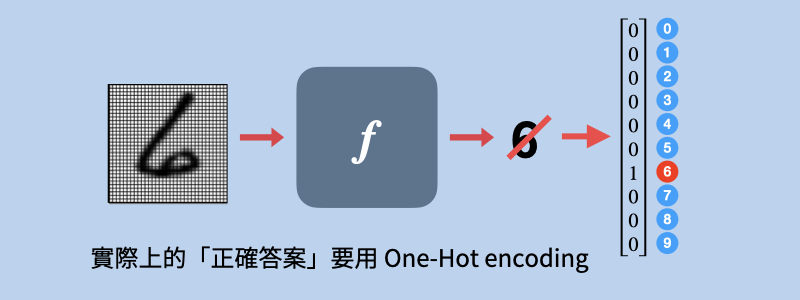

可能會想, 想學的函數是這樣的型式:

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}$$

其實這樣不太好! 為什麼呢? 比如說輸入 x 是一張 0 的圖, 因為訓練的神經網路總會有點誤差, 所以可能會得到:

$$\hat{f}(x) = 0.5$$

那這意思是有可能是 0, 也有可能是 1 嗎!!?? 可是 0 和 1 根本不像。換句話說分類的問題這樣做其實不合理!

於是會做 "1-hot enconding", 也就是

* 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
* 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0]



In [6]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## 3 建構神經網路

和以前做迴歸或機器學習一樣, 我們就打開個「函數學習機」。標準一層一層傳遞的神經網路叫 `Sequential`, 於是打開一個空的神經網路。

In [7]:
model = Sequential()

每次用 `add` 去加一層, 從第一個隱藏層開始。而第一個隱藏層因為 TensorFlow 當然猜不到輸入有 784 個 features, 所以要告訴它。

In [8]:
# model.add(Dense(N1, input_dim=784, activation='relu'))
model.add(Dense(N1, input_dim=784, activation='gelu'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


第二層開始就不用再說明輸入神經元個數 (因為就是前一層神經元數)。

In [9]:
# model.add(Dropout(0.2))
# model.add(Dense(N2, activation='relu'))
model.add(Dense(N2, activation='gelu'))

In [10]:
# model.add(Dropout(0.2))
# model.add(Dense(N3, activation='relu'))
model.add(Dense(N3, activation='gelu'))

In [11]:
# model.add(Dropout(0.2))
# model.add(Dense(N4, activation='relu'))
model.add(Dense(N4, activation='gelu'))

In [12]:
# model.add(Dense(N5, activation='relu'))
model.add(Dense(N5, activation='gelu'))

In [13]:
model.add(Dense(N6, activation='softmax'))

### 神經網路架構嘗試歷程：
- 激發函數嘗試使用過Relu 、 Gelu
- 嘗試在各層神經元中間加上Dropout技術
- 模型loss function嘗試過MSE 、Cross Entrophy
#### 最終經過多次測試後，最終模型架構決定使用Gelu作為激發函數，不使用Dropout技術，loss function則採用 Cross Entrophy，此種架構訓練出的模型準確率最佳。





為了一邊訓練一邊看到結果, 加設

    metrics=['accuracy']
    
本行基本上和神經網路功能沒有什麼關係。

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.05), metrics=['accuracy'])

## 4. 檢視神經網路

### 4.1 看 model 的 summary

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │          23,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │             630 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             310 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,540 (99.77 KB)

 Trainable params: 25,540 (99.77 KB)

 Non-trainable params: 0 (0.00 B)

## 5. 訓練第一個神經網路


* 一次要訓練幾筆資料 (`batch_size`),  100 筆調一次參數
* 這 6 萬筆資料一共要訓練幾次 (`epochs`), 訓練 10 次



In [16]:
model.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3536 - loss: 1.8582
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8974 - loss: 0.3437
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9337 - loss: 0.2241
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9484 - loss: 0.1766
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9538 - loss: 0.1538
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9607 - loss: 0.1354
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9647 - loss: 0.1219
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9671 - loss: 0.1092
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9698 - loss: 0.1032
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9717 - loss: 0.0941


## 6. 試用結果


In [17]:
loss, acc = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9572 - loss: 0.1416


In [18]:
print(f"測試資料正確率 {acc*100:.2f}%")

測試資料正確率 96.29%


"predict" 放的是神經網路的學習結果。做完之後用 argmax 找到數值最大的那一項。

In [19]:
predict = np.argmax(model.predict(x_test), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [20]:
predict

array([7, 2, 1, ..., 4, 5, 6])

因先前`x_test` 每筆資料已經換成 784 維的向量, 需轉換回 28x28 的矩陣才能當成圖形顯示出

In [21]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

In [23]:
interact_manual(test, 測試編號=(0, 9999));

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

神經網路「總評量」分數

In [24]:
score = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9572 - loss: 0.1416


In [25]:
print('loss:', score[0])
print('正確率', score[1])

loss: 0.12183913588523865
正確率 0.9628999829292297


### 7. 用 Gradio 來展示

In [26]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [27]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9f5cd738aaad059adc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
